# **Final Project:**
# **Modeling Cryptocurrency Usage in Consumer Transactions**
***

## **Problem Statement**
Cryptocurrencies are, collectively, the fastest growing asset class. In comparison with other assets such as government-issued currencies, gold, real estate, equities, and debt obligations, the aggregate market value of cryptocurrencies remains very small. However, the rapid growth in the market value of this new asset class compels government agencies to develop appropriate regulations to protect consumers, tax, incentivize or disincentivize usage, etc.

A key difficulty in developing these regulations is determining whether cryptocurrencies are primarily:

* assets (stores of value), 
* currencies (instruments of exchange), or 
* purely speculative instruments (akin to poker chips). 

All three classifications are represented in the regulatory regimes of different governments. The original goal of the creator(s) of the first cryptocurrency, Bitcoin, was to establish a new form of currency. Unites States regulations, which are still under development and are not entirely consistent, generally treat cryptocurrencies as assets. Popular opinion holds that pure speculation currently dominates cryptocurrency usage.

Predicting the trends in each of these types of usage can help guide the development of appropriate government regulation. The goal of this exercise is to model cryptocurrency useage as a currency on the basis of various crypto market measures. So for example, if a government finds value (or not) in facilitating the use of crypto as a form of currency, regulations could be developed to influence these factors. Developers of new cryptocurrencies could similarly influence these factors by design.

Since the world-wide market capitalization of Bitcoin is currently 75% of the entire cryptocurrency market, Bitcoin data will be analyzed as a proxy for all cryptocurrency usage.


***
## **Model Targets and Features**

The general charactaristics of the three potential classifications of cryptocurrencies are:
* Asset: low volume of relatively large transactions, low price volitility
* Currency: high volume of relatively small transactions, low price volitility
* Speculation: high price volitility

This model aims to predict the total value of all transactions divided by the number of transactions, i.e., the average transaction value. A lower average indicates currency-like useage and a high average, asset-like usage. Both of these should be strongly and inversely correlated with price volitility as high volitility reduces the utility of a financial instrument for either the purchase of goods and services or as a store of value. Therefore volitility should be a useful feature variable in the model. For transaction volume, the median will be used as the method of averaging based upon the reasoning that median will better capture the higher volume of small transactions and be less influenced by a few, large transactions which would distort a mean average.

The historical data that will be used was sourced from Coin Metrics: https://coinmetrics.io/ and contains daily measurements of BTC transactions since the launch of the BTC blockchain, 1/3/2009

The features from this dataset that will be used in this model are:

* Number of Users Transacting
* Money supply of BTC
* Average Transaction Fees
* Price of BTC in USD
* Number of Transactions
* Price Volitility

Below are the columns from the data set that will be used to represent these features. 

| Name In Data File     | Simple Name   | Target/Feature                                       | Definition                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|-----------------|--------------------------------------------------------|-----------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| AdrActCnt       | Users | Feature                             | The sum count of unique addresses that were active in the network \(either as a recipient or originator of a ledger change\) that day\. All parties in a ledger change action \(recipients and originators\) are counted\. Individual addresses are not double\-counted if previously active\.                                                 
| CapMrktCurUSD   | Supply | Feature           | The sum USD value of the current supply\. Also referred to as network value or market capitalization\.     
| FeeMeanUSD       | Avg_Fee    | Feature                     | The USD value of the median fee per transaction that day\. 
| PriceUSD        | Price              | Feature                               | The fixed closing price of the asset as of 00:00 UTC the following day \(i\.e\., midnight UTC of the current day\) denominated in USD\. This price is generated by Coin Metrics' fixing/reference rate service\.                                                                                                                           
| TxTfrValAdjNtv  | Transactions | Feature | The sum of native units transferred that day removing noise and certain artifacts\.               
| TxTfrValMedUSD  | Average Transaction Value   | Target         | The median USD value transferred per transfer \(i\.e\., the median "size" in USD of a transfer\) that day\.                                                                                                       
| VtyDayRet180d   | Volatility    | Feature                    | The 180D volatility, measured as the deviation of log returns\.              

***
# **Data Preparation**

#### **Import Libraries and the Dataset**

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

btc_raw = pd.read_csv('btc.csv')            # Comma is default separator, but specify just in case

#### **Select only Relevant Columns and Rename Them**

In [71]:
columns = [
    "date",
    "AdrActCnt",
    "CapMrktCurUSD",
    "FeeMeanUSD",
    "PriceUSD",
    "TxTfrValAdjNtv",
    "TxTfrValMedUSD",
    "VtyDayRet180d"
]
btc = btc_raw.loc[:, columns]

simple_names = [
    "date",
    "Users",
    "Supply",
    "Avg_Fee",
    "Price",
    "Num_Transactions",
    "Avg_Transaction_Value",
    "Volatility"
]
btc.columns = simple_names

#### **Quick Review of Data Quality**

There are no missing dates:

In [72]:
beginning = btc['date'][0]
end = btc['date'][btc_raw.shape[0]-1]

# Change these strings to timestamps
beginning = pd.Timestamp(beginning)
end = pd.Timestamp(end)

cal = pd.date_range(beginning, end)    # Create the series of all dates within the date range of the btc data set
btc_dates = btc['date']            # Split the series of all dates within the btc data set
cal.shape[0] == btc_dates.shape[0]     # Verify there are no missing dates

True

There is a significant amount of missing data, but no feature was collected on less than 75% of the trading days. Also, there are no nulls in date column:

In [73]:
btc.replace(0, np.nan, inplace=True)    # For this data, 0's are meaningless and imply no data
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4133 entries, 0 to 4132
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   4133 non-null   object 
 1   Users                  4127 non-null   float64
 2   Supply                 3572 non-null   float64
 3   Avg_Fee                3492 non-null   float64
 4   Price                  3572 non-null   float64
 5   Num_Transactions       3873 non-null   float64
 6   Avg_Transaction_Value  3572 non-null   float64
 7   Volatility             3392 non-null   float64
dtypes: float64(7), object(1)
memory usage: 258.4+ KB


#### **Remove Rows with Missing Data**

January 3, 2009 was the start date of the Bitcoin blockchain and not all features were collected at the beginning of its trading. Delete all rows before the first row with complete data and verify that all remaining rows have complete data. From above, the total number of rows are 4133 and the column with the least non-nulls is Volatility, with 3392. Delete the first 4133 - 3392 = 741 rows and verify that the remaining data is complete.

In [74]:
btc = btc.loc[741:,:]
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3392 entries, 741 to 4132
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   3392 non-null   object 
 1   Users                  3392 non-null   float64
 2   Supply                 3392 non-null   float64
 3   Avg_Fee                3392 non-null   float64
 4   Price                  3392 non-null   float64
 5   Num_Transactions       3392 non-null   float64
 6   Avg_Transaction_Value  3392 non-null   float64
 7   Volatility             3392 non-null   float64
dtypes: float64(7), object(1)
memory usage: 212.1+ KB


#### **Since time will not be included in the model, drop the Date column**

In [75]:
# Remove these constituents and the date column
btc = btc.drop(["date"], axis=1)

***
# **Exploratory Data Analysis**

#### **Visualize the distribution of the data**

In [76]:
btc_raw.loc[:, columns].tail()

,date,AdrActCnt,CapMrktCurUSD,FeeMeanUSD,PriceUSD,TxTfrValAdjNtv,TxTfrValMedUSD,VtyDayRet180d
4128,2020-04-23,935989,1.373549e+11,0.943012,7488.605165,277328.540079,89.511298,0.049507
4129,2020-04-24,893187,1.376956e+11,0.856430,7506.443316,318106.462333,79.611086,0.049442
4130,2020-04-25,813456,1.382825e+11,0.746464,7537.738209,136098.393403,73.860789,0.049411
4131,2020-04-26,724250,1.409801e+11,0.637815,7684.068522,116921.340151,71.442473,0.049425
4132,2020-04-27,876229,1.427079e+11,0.701957,7777.491519,240549.252515,81.274786,0.049397


In [77]:
btc.describe()

,Users,Supply,Avg_Fee,Price,Num_Transactions,Avg_Transaction_Value,Volatility
count,3.392000e+03,3.392000e+03,3392.000000,3392.000000,3.392000e+03,3.392000e+03,3392.000000
mean,3.770560e+05,4.252512e+10,1.040760,2478.808687,2.993208e+05,3.528014e+01,0.049260
std,3.029400e+05,6.312157e+10,3.839532,3605.650039,1.585904e+05,5.122775e+01,0.021686
min,1.273000e+03,1.617845e+06,0.000021,0.312990,3.080008e+04,8.203471e-08,0.020298
25%,6.569875e+04,1.076556e+09,0.035778,94.267802,1.869101e+05,4.011328e+00,0.032678
50%,3.098225e+05,6.745885e+09,0.108901,467.692045,2.698654e+05,1.445886e+01,0.042476
75%,6.438952e+05,7.022484e+10,0.635376,4095.425052,3.869515e+05,6.146467e+01,0.060065
max,1.290363e+06,3.288988e+11,56.308124,19640.513883,2.090898e+06,5.348536e+02,0.109532


In [78]:
target = "Avg_Transaction_Value"
target_col = btc.loc[:, target]
feature_cols = btc.drop(target, axis=1)

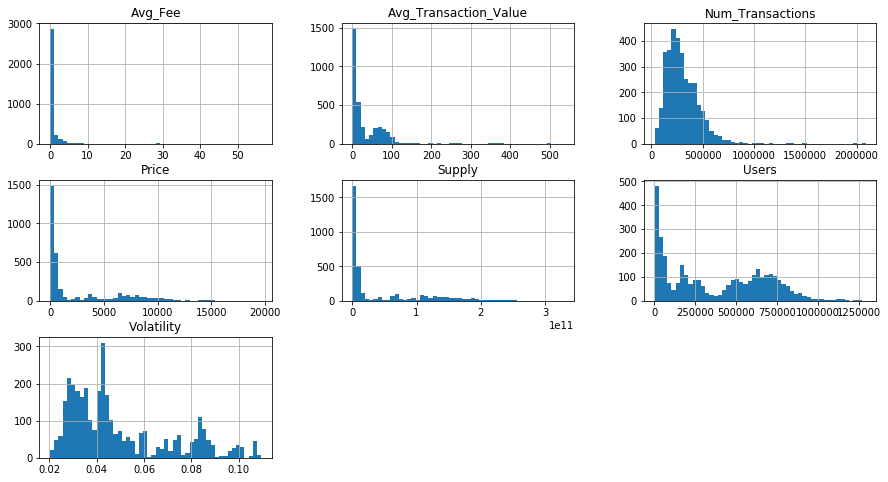

In [79]:
btc.hist(figsize=(15,8), bins=50);

Since Price, Avg_Fee, Avg_Transaction_Value, Price, and Supply have extreme skew, 
take the log of each of these to reduce this charactaristic.\
NOTE: Keep in mind that the y-axes of the log_columns charted below are not labled as such

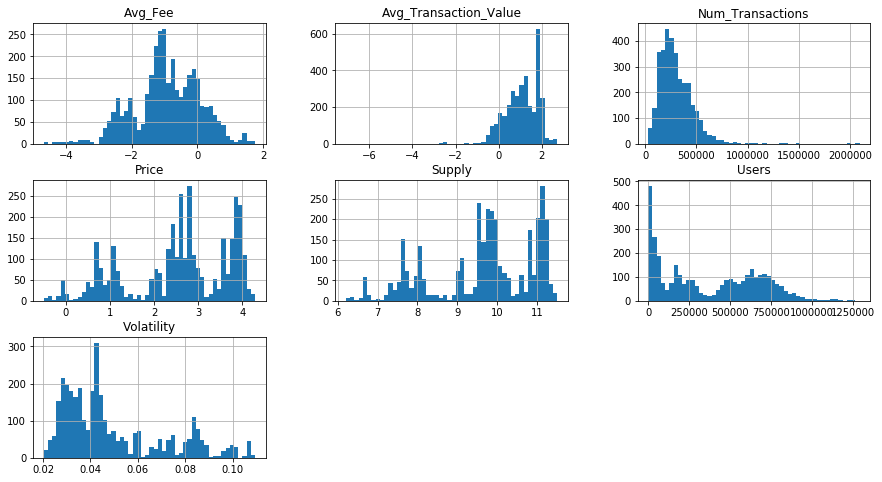

In [80]:
log_columns = ["Avg_Fee", "Avg_Transaction_Value", "Price", "Supply"]
for feature in log_columns:
    btc.loc[:, feature] = btc.loc[:, feature].apply(lambda x : np.log10(x))
btc.hist(figsize=(15,8), bins=50);

Now that some features have been scaled, visualize additional statistics.

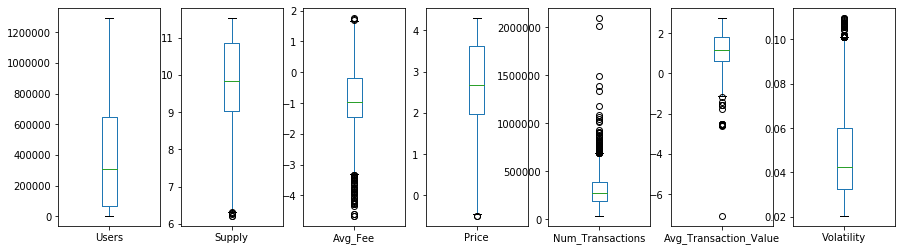

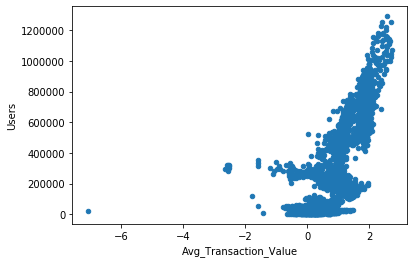

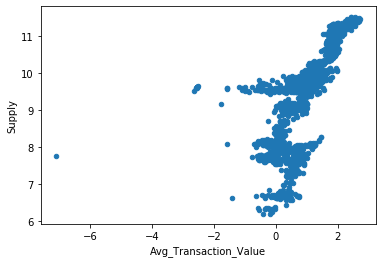

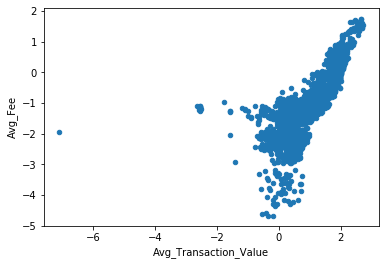

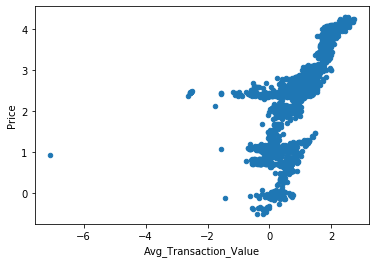

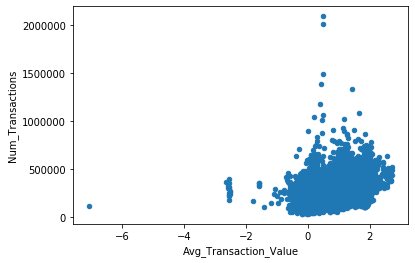

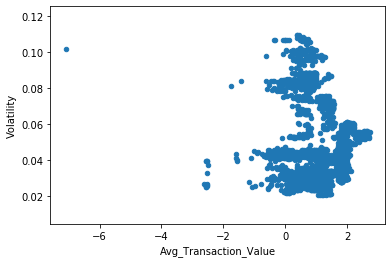

In [81]:
btc.plot.box(subplots=True, figsize=(15,4));

for column in feature_cols:
    btc.plot.scatter(x=target, y=column)

View the target and each feature as a function of time. Although no dates are shown, the data remains in date order.

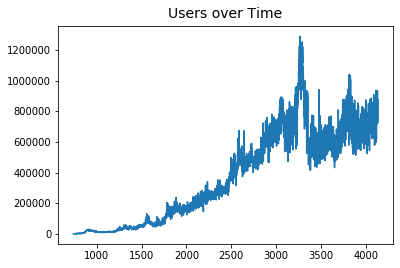

In [82]:
ax = btc.loc[:, "Users"].plot();
ax.set_title("Users over Time", fontsize=14, y=1.01);

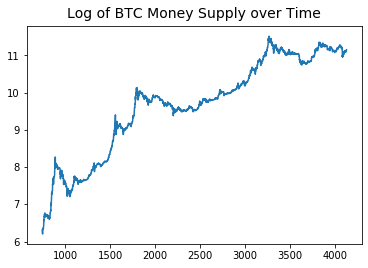

In [83]:
ax = btc.loc[:, "Supply"].plot();
ax.set_title("Log of BTC Money Supply over Time", fontsize=14, y=1.01);

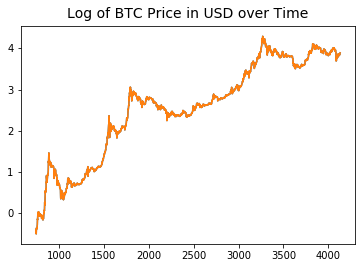

In [84]:
btc.loc[:, "Price"].plot()
ax = btc.loc[:, "Price"].plot();
ax.set_title("Log of BTC Price in USD over Time", fontsize=14, y=1.01);

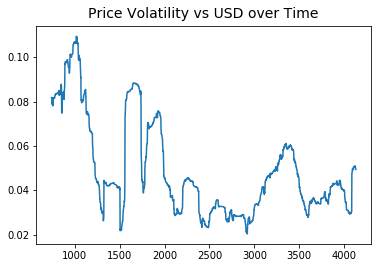

In [85]:
fig, ax = plt.subplots()
ax = btc.loc[:, "Volatility"].plot();
ax.set_title("Price Volatility vs USD over Time", fontsize=14, y=1.01);
fig.savefig("Volatility.png")

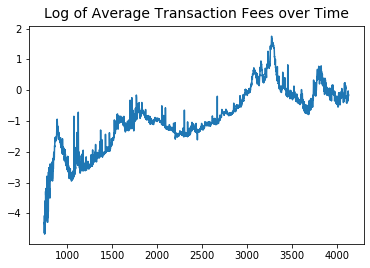

In [86]:
ax = btc.loc[:, "Avg_Fee"].plot();
ax.set_title("Log of Average Transaction Fees over Time", fontsize=14, y=1.01);

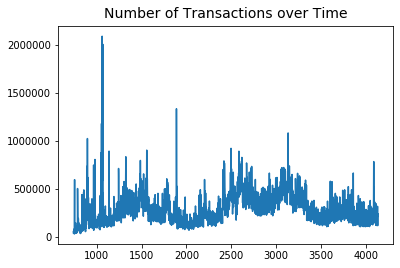

In [87]:
ax = btc.loc[:, "Num_Transactions"].plot();
ax.set_title("Number of Transactions over Time", fontsize=14, y=1.01);

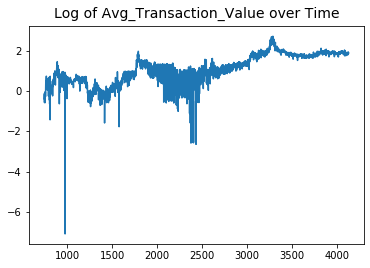

In [88]:
ax = btc.loc[:, "Avg_Transaction_Value"].plot()
ax.set_title('Log of Avg_Transaction_Value over Time', fontsize=14, y=1.01);

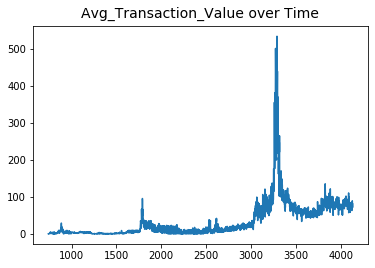

In [89]:
ax = btc.loc[:, "Avg_Transaction_Value"].apply(lambda x : 10**(x)).plot()
ax.set_title('Avg_Transaction_Value over Time', fontsize=14, y=1.01);

Visualize the correlation of the features with the target and each other

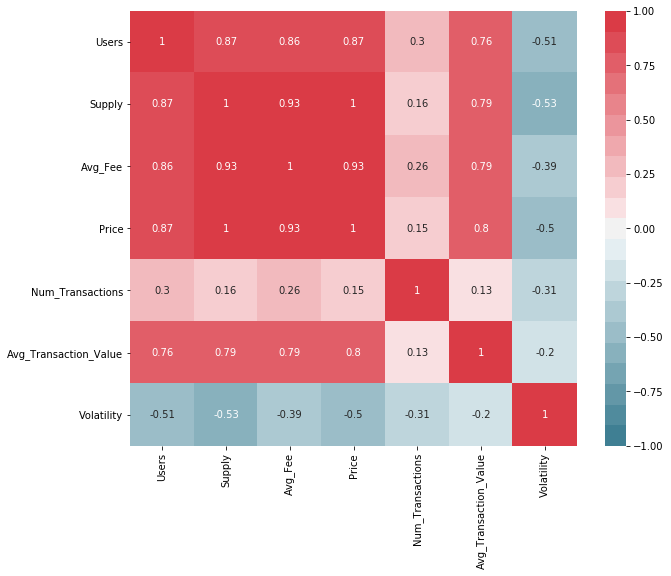

In [90]:
ax = sns.heatmap(
    btc.corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(220, 10, n=21),
    annot=True,
)
ax.get_figure().set_size_inches(10, 8)

#### **Analysis**

* The decrease in price volatility over time argues against BTC being a purely speculative instrument. Thus BTC should be seen as either an asset or a currency.
* Most features trend over time. Since this model ignores time, a subsequent time-series analysis might significantly improve any predictive model.
* Arbitrarily taking the log of average transaction value, money supply, price, and transaction fees may make any model difficult to interpret economically.
* Avg_Fee, Users, and Price are all highly correlated to each other. From an economic perspective, if any of these should be dropped, it would be Avg_Fee as it may add no additional information versus Price if one is a direct function of the other by definition; the author does not know if this is the case.
* That the number of users is correlated to price is not a surprise, considering investor FOMA. However, the difference between masses of investors in BTC and masses of consumers using BTC to purchase goods and services may be impossible to distinguish using the data in this set. 

***
## **Predictive Modeling**

#### **Linear Regression**

In [91]:
# Assign the target column to predict, "y," and the feature columns used to make predictions, "X" 
y = target_col
X = feature_cols

# Train the model on 75% of the data and test on the other 25% (which is the default)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Import and instantiate the Random Forest Regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Fit and score this model on the data
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.6735732618099466
0.6205262322531819


Note from the exploratory data analysis that the outliers are very concentrated in time. Since the training set is 3 times larger than the test set, the training set will typically have all or most of these and the test set will have fewer or none. This explains why the test set score is sometimes, but not always, higher than the training set.

Since I am ignoring time in this model, I can perform cross validation and shuffle the data to stabilize the results.\
Running the code below multiple times confirms this result.

In [92]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True)

lr_grid = GridSearchCV(
    estimator=LinearRegression(),
    cv=kf,
    param_grid={},
    return_train_score=True,
)
lr_grid.fit(X, y)
pd.DataFrame(lr_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,0.660452,0.664585


Here is a look at the relative importance of the features in this model. Since some coeficients are negative, take the absolute value for clarity.

In [93]:
pd.DataFrame({"feature": feature_cols.columns, "coeficients": np.abs(lr.coef_)}).sort_values(by="coeficients", ascending=False)

,feature,coeficients
5,Volatility,7.338025e+00
2,Avg_Fee,3.644109e-02
3,Price,8.377656e-04
0,Users,1.824626e-06
4,Num_Transactions,6.393590e-08
1,Supply,4.429251e-11


From the magnitudes of these coeficients, it might seem dropping Users and Supply would have little effect and allow a simplification of the model.

Additionally, I speculated above that since Avg_Fee and Price and Supply are highly correlated dropping one of these might improve the model.

Let's  try dropping each individual feature and training the model on all of the others to see if any one has significant impact.

In [94]:
# A function for dropping features
def drop_features(df, feature_list):
    return(df.drop(feature_list, axis=1))

# A function for droping each individual feature and training with all of the others on a particular model class
def drop_each_feature(X, estimator, feature_list):
    for feature in feature_cols.columns:
        X_mod = drop_features(X, feature)
        lr_grid = GridSearchCV(
            estimator=estimator,
            cv=kf,
            param_grid={},
            return_train_score=True,
        )
        lr_grid.fit(X_mod, y)
        print('\033[1m' + "Droped " + feature + '\033[0m')
        print(pd.DataFrame(lr_grid.cv_results_).loc[:, ["mean_train_score", "mean_test_score"]])
        print("")
        
drop_each_feature(X, lr, feature_cols.columns)

Droped Users
   mean_train_score  mean_test_score
0          0.559013         0.560984

Droped Supply
   mean_train_score  mean_test_score
0          0.645144         0.645094

Droped Avg_Fee
   mean_train_score  mean_test_score
0          0.645945         0.654512

Droped Price
   mean_train_score  mean_test_score
0          0.643486         0.648041

Droped Num_Transactions
   mean_train_score  mean_test_score
0          0.660401         0.668094

Droped Volatility
   mean_train_score  mean_test_score
0          0.641135         0.645774



Apparently the bias inherent in this simple linear model does not improve with feature selection. Indeed, the module benefits from having the full set on which to train.

The error rates of the best model are reasonably well centered on the data over time. The apparent reduction in the variation of errors is interesting and may indicate some form of economic stabilization in the use of BTC:

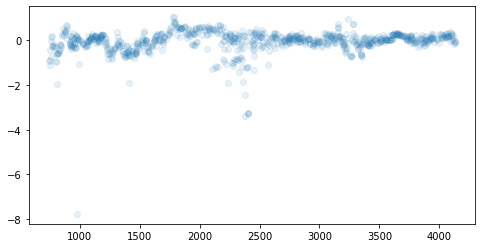

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
lr.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 4))
residuals = y_test - lr.predict(X_test)
ax.scatter(x=X_test.index, y=residuals, alpha=0.1);

#### **Random Forest Regression**

In [96]:
# Note, the model fit method below throws a warning that there will be coding changes in future versions. For this report, I will spress these.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assign the target column to predict, "y," and the feature columns used to make predictions, "X" 
y = target_col
X = feature_cols

# Train the model on 75% of the data and test on the other 25% (which is the default)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Import and instantiate the Random Forest Regression model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100)

# Fit and score this model on the data
rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9798661817079457
0.9139779874677633


This model is overfitting, although not badly.\
Here is how this model weighs the input features:

In [97]:
pd.DataFrame({"feature": feature_cols.columns, "importance": rfr.feature_importances_}).sort_values(by="importance", ascending=False)

,feature,importance
3,Price,0.655071
1,Supply,0.106613
2,Avg_Fee,0.074118
0,Users,0.060678
5,Volatility,0.056511
4,Num_Transactions,0.047010


As with the Linear Regression model, dropping one feature at a time and rerunning the model does not improve the model's accuracy.

I did note that running the model with all features multiple times delivers more consistent scores than running the model with any feature removed, i.e., more features stabilizes the predictions

In [98]:
drop_each_feature(X, rfr, feature_cols.columns)

Droped Users
   mean_train_score  mean_test_score
0          0.980277         0.867143

Droped Supply
   mean_train_score  mean_test_score
0          0.982547         0.885181

Droped Avg_Fee
   mean_train_score  mean_test_score
0          0.981815         0.876143

Droped Price
   mean_train_score  mean_test_score
0          0.982579         0.892324

Droped Num_Transactions
   mean_train_score  mean_test_score
0          0.980067         0.854395

Droped Volatility
   mean_train_score  mean_test_score
0          0.980371         0.859258



This model is far superior to the linear regression model above. Again, note the apparent reduction in the variation of errors over time:

Text(0.5, 0, 'Sample Days')

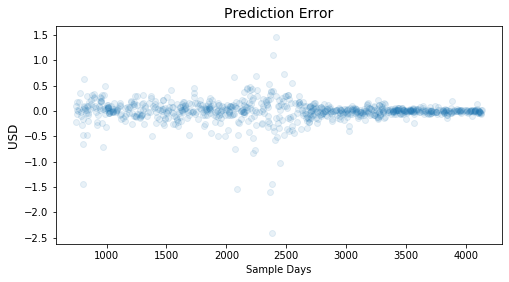

In [99]:
# Note this model is far superior to the linear regression model above
fig, ax = plt.subplots(figsize=(8, 4))
residuals = y_test - rfr.predict(X_test)
ax.scatter(x=X_test.index, y=residuals, alpha=0.1);
ax.set_title('Prediction Error', fontsize=14, y=1.01);
ax.set_ylabel("USD", fontsize=12)
ax.set_xlabel("Sample Days")

Export this chart for presentation

In [100]:
fig.savefig("RFR_Errors.png")


***
## **Suggestions for Further Model Development**
* The source data is end-of-day time-series; this model ignores time. Analysis of trends in time could add predictive value.
* The selection of the data from the dataset intended to represent the target features should be challenged.
* The features input into this model do not have the ability to distinguish between small investment transactions and purchases of goods and services. Data that could help to distinguish between these two should improve the validity of the model's conclusions.
* This model does not include trends in consumer usage of USD. Adding this trend information or perhaps measuring this data against a basket of currencies rather than USD alone should improve the validity of the model's conclusions
* Conclusions reached in this report could be enhanced by developing similar predictive model for asset usage or developing a classification model to distinguish between asset and currency usage.